In [2]:
from pandas import read_csv
import datetime
from pandas import concat
import numpy as np
# load data
def parse(x):
	return datetime.datetime.strptime(x, '%Y %m %d %H')

# 첫 주행 날짜
first_date = datetime.datetime.strptime("20220801", "%Y%m%d")
first_date_str = str(first_date)
first_date_str = first_date_str[:first_date_str.find(' ')].replace('-', '')
print(first_date_str)
print(first_date)
# 현재 날짜
now_date  = datetime.datetime.now()

# 받아올 데이터 일수
read_time = str(now_date - first_date)
read_time = int(read_time[:read_time.find(' ')])
print(read_time)

dataset = []

# 역대 환경 데이터를 모두 읽어옴
for i in range(read_time+1):
	read_file_name = str(first_date + datetime.timedelta(days = i))
	read_file_name = read_file_name[:read_file_name.find(' ')].replace('-', '')
	print(read_file_name)
	dataset.append(read_csv('C:\LSTM\dataset' + '\\fake_data_' + read_file_name +'.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse))

dataset = concat([dataset[i] for i in range(len(dataset))], axis=0)
dataset.drop('No', axis=1, inplace=True) 
# manually specify column names
dataset.columns = ['local', 'temp', 'humidity', 'metter']
dataset.index.name = 'date'

print(dataset.head(5)) 
# save to file
dataset.to_csv('C:\LSTM\dataset\pollution.csv')
print(dataset)

20220801
2022-08-01 00:00:00
25
20220801
20220802
20220803
20220804
20220805
20220806
20220807
20220808
20220809
20220810
20220811
20220812
20220813
20220814
20220815
20220816
20220817
20220818
20220819
20220820
20220821
20220822
20220823
20220824
20220825
20220826
                     local  temp  humidity  metter
date                                              
2022-08-01 09:00:00      1  23.5      38.3       3
2022-08-01 09:00:00      2  23.6      37.0       3
2022-08-01 09:00:00      3  23.8      35.0       3
2022-08-01 09:00:00      4  23.9      34.0       3
2022-08-01 09:00:00      5  23.3      33.5       2
                     local  temp  humidity  metter
date                                              
2022-08-01 09:00:00      1  23.5      38.3       3
2022-08-01 09:00:00      2  23.6      37.0       3
2022-08-01 09:00:00      3  23.8      35.0       3
2022-08-01 09:00:00      4  23.9      34.0       3
2022-08-01 09:00:00      5  23.3      33.5       2
...                 

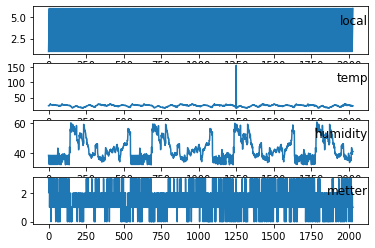

In [3]:
from matplotlib import pyplot
# load dataset
dataset = read_csv('C:\LSTM\dataset\pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [4]:
# prepare data for lstm
from pandas import DataFrame

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	# print(df)
	cols, names = list(), list()
	# 7일 전의 환경 데이터를 input, 7일 후의 환경 데이터를 target으로 설정
	cols.append(df.shift(6*13*7))
	names += [('var%d(t-%d)' % (j+1, 7)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	cols.append(df)
	names += [('var%d(t)' % (j+1)) for j in range(n_vars)]

	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	# drop columns we don't want to predict
	agg.drop(agg.columns[[3,4]], axis=1, inplace=True)
	
	# 구역에 따라  환경데이터를 묶어준다.
	local = agg[['var1(t-7)',  'var2(t-7)',  'var3(t-7)']].values
	local = local.reshape(13*int((local.shape[0]/13/6)),6,3)
	label = agg['var3(t)'].values
	label = label.reshape(13*int((label.shape[0]/13/6)),6)
	return local, label

# load dataset
dataset = read_csv('C:\LSTM\dataset\pollution.csv', header=0, index_col=0)
values = dataset.drop(['local'], axis = 1).values
# integer encode direction
encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed, target = series_to_supervised(scaled, 1, 1)
print(reframed.shape, target.shape)

(247, 6, 3) (247, 6)


In [5]:
# split into train and test sets
values = reframed
# 5일치를 학습시킴
n_train_hours = int(values.shape[0]/13/3)*2*13
train_X, train_y = values[:n_train_hours], target[:n_train_hours]
test_X,  test_y  = values[n_train_hours:], target[n_train_hours:]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X, train_y)

(156, 6, 3) (156, 6) (91, 6, 3) (91, 6)
[[[0.05928016 0.22145319 1.        ]
  [0.05998588 0.17647052 1.        ]
  [0.06139731 0.10726643 1.        ]
  [0.06210303 0.07266426 1.        ]
  [0.05786873 0.0553633  0.6666667 ]
  [0.05716302 0.01038063 0.6666667 ]]

 [[0.06633732 0.22145319 1.        ]
  [0.0733945  0.17647052 0.33333334]
  [0.0825688  0.10726643 0.6666667 ]
  [0.08327452 0.07266426 0.33333334]
  [0.08609738 0.0553633  0.33333334]
  [0.09244884 0.01038063 0.33333334]]

 [[0.10444602 0.22145319 1.        ]
  [0.09668312 0.17647052 0.33333334]
  [0.0825688  0.10726643 0.6666667 ]
  [0.08327452 0.07266426 0.33333334]
  [0.08045166 0.0553633  0.        ]
  [0.07692308 0.01038063 0.33333334]]

 ...

 [[0.06139731 0.1522491  0.6666667 ]
  [0.06210303 0.14878893 0.33333334]
  [0.06139731 0.12456739 0.33333334]
  [0.07551164 0.15570939 0.        ]
  [0.05857445 0.11418688 0.33333334]
  [0.06774876 0.14186847 0.33333334]]

 [[0.06633732 0.28027678 0.6666667 ]
  [0.0733945  0.28719

In [6]:

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import BatchNormalization
from sklearn.metrics import mean_squared_error
max_acc         = 0
max_lstm_node   = 0
max_Dense1_node = 0
max_Dense2_node = 0
max_Dense3_node = 0
max_epoch       = 0

lstm_node = 5
Dense1_node = 1
Dense2_node = 1
Dense3_node = 1
epoch       = 10


#while loof trainig
while(lstm_node<=1000):
    # design network
    for i in range(0,1000,5):
        for j in range(0,1000):
            for k in range(0, 1000):
                for l in range(0, 200):
                    model = Sequential()
                    model.add(LSTM(lstm_node, input_shape=(train_X.shape[1], train_X.shape[2]), activation="softsign", recurrent_activation="elu"))
                    model.add(Dense(Dense1_node))
                    model.add(Dense(Dense2_node))
                    model.add(Dense(Dense3_node))
                    model.add(Dense(6))
                    model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
                    # fit network
                    history = model.fit(train_X, train_y, epochs=epoch , batch_size=6, validation_data=(test_X, test_y),
                                        verbose=2, shuffle=False, validation_split = 0.1)

                    loss, acc = model.evaluate(test_X, test_y, batch_size=1)
                    if max_acc < acc:
                        max_acc = acc
                        max_lstm_node   = lstm_node
                        max_Dense1_node = Dense1_node
                        max_Dense2_node = Dense2_node
                        max_Dense3_node = Dense3_node
                    epoch   += 5
                epoch        = 5
                Dense1_node += 1
            Dense1_node      = 1
            Dense2_node     += 1
        Dense2_node          = 1
        Dense3_node         += 1
    Dense3_node              = 1
    lstm_node               += 5

    
    # # plot historyz
    # pyplot.xlabel("epoch")
    # pyplot.ylabel("loss")
    # pyplot.plot(history.history['loss'], label='train')
    # pyplot.plot(history.history['val_loss'], label='test')
    # pyplot.legend()
    # pyplot.show()
print("max_acc         : ", max_acc)
print("max_lstm_node   : ", max_lstm_node)
print("max_Dense1_node : ", max_Dense1_node)
print("max_Dense2_node : ", max_Dense2_node)
print("max_Dense3_node : ", max_Dense3_node)
print("max_epoch       : ", max_epoch)


Epoch 1/10
26/26 - 3s - loss: 0.4720 - accuracy: 0.7436 - val_loss: 0.4606 - val_accuracy: 0.7582 - 3s/epoch - 119ms/step
Epoch 2/10
26/26 - 0s - loss: 0.4375 - accuracy: 0.7436 - val_loss: 0.4240 - val_accuracy: 0.7582 - 196ms/epoch - 8ms/step
Epoch 3/10
26/26 - 0s - loss: 0.3931 - accuracy: 0.7436 - val_loss: 0.3751 - val_accuracy: 0.7582 - 201ms/epoch - 8ms/step
Epoch 4/10
26/26 - 0s - loss: 0.3435 - accuracy: 0.7436 - val_loss: 0.3325 - val_accuracy: 0.7582 - 229ms/epoch - 9ms/step
Epoch 5/10
26/26 - 0s - loss: 0.3076 - accuracy: 0.7436 - val_loss: 0.2924 - val_accuracy: 0.7582 - 200ms/epoch - 8ms/step
Epoch 6/10
26/26 - 0s - loss: 0.2696 - accuracy: 0.7436 - val_loss: 0.2611 - val_accuracy: 0.7582 - 204ms/epoch - 8ms/step
Epoch 7/10
26/26 - 0s - loss: 0.2482 - accuracy: 0.7436 - val_loss: 0.2472 - val_accuracy: 0.7582 - 211ms/epoch - 8ms/step
Epoch 8/10
26/26 - 0s - loss: 0.2333 - accuracy: 0.7436 - val_loss: 0.2345 - val_accuracy: 0.7582 - 208ms/epoch - 8ms/step
Epoch 9/10
26/26 

In [ ]:
    # # make a prediction
    prediction = model.predict(test_X)
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_y, prediction))
    print('Test RMSE: %.3f' % rmse)
    loss, acc = model.evaluate(test_X, test_y, batch_size=1)
    print("loss : ", loss)
    print("acc : " , acc)

    # R2 구하기
    from sklearn.metrics import r2_score
    r2_y_predict = r2_score(test_y, prediction)
    print("R2 : ", r2_y_predict)


3/3 [==============================] - 0s 2ms/step
Test RMSE: 0.228
91/91 [==============================] - 0s 1ms/step - loss: 0.1723 - accuracy: 0.7802
loss :  0.17227400839328766
acc :  0.7802197933197021
R2 :  0.0991706557660696


In [9]:

# 다음 날의 주행을 예측하기 위해서는 현재로부터 6일 전의 데이터를 넣고 추출시켜야 함
tst_tim = str(datetime.datetime.now() - datetime.timedelta(days = 6))
tst_tim = tst_tim[:tst_tim.find(' ')].replace('-', '')
print(tst_tim)

predic_data = []
predic_data.append(read_csv('C:\LSTM\dataset' + '\\fake_data_' + tst_tim +'.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse))


predic_data = concat([predic_data[i] for i in range(len(predic_data))], axis=0)
predic_data.drop('No', axis=1, inplace=True) 
# manually specify column names
predic_data.columns = ['local', 'temp', 'humidity', 'metter']
predic_data.index.name = 'date'

print(predic_data.head(5)) 

predic_values = predic_data.drop(['local'], axis = 1).values
# integer encode direction
encoder = LabelEncoder()
# ensure all data is float
predic_values = predic_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
predic_scaled = scaler.fit_transform(predic_values)
# frame as supervised learning
predic_scaled = predic_scaled.reshape(13,6,3)
predic = np.array(model.predict(predic_scaled))
print(predic_scaled)

20220818
                     local  temp  humidity  metter
date                                              
2022-08-18 09:00:00      1  18.5      59.3       2
2022-08-18 09:00:00      2  18.5      58.2       1
2022-08-18 09:00:00      3  18.6      58.4       1
2022-08-18 09:00:00      4  18.8      56.8       1
2022-08-18 09:00:00      5  18.4      57.7       1
1/1 [==============================] - 0s 25ms/step
[[[0.02531648 1.0000001  0.6666667 ]
  [0.02531648 0.951542   0.33333334]
  [0.03797483 0.96035254 0.33333334]
  [0.06329107 0.8898679  0.33333334]
  [0.01265812 0.9295155  0.33333334]
  [0.12658215 0.8942734  0.33333334]]

 [[0.11392426 0.828194   0.33333334]
  [0.16455698 0.8325993  0.6666667 ]
  [0.         0.79295146 0.6666667 ]
  [0.18987322 0.7753304  0.33333334]
  [0.20253158 0.7797357  0.33333334]
  [0.01265812 0.81057274 0.33333334]]

 [[0.06329107 0.72246706 0.6666667 ]
  [0.05063295 0.7312776  0.33333334]
  [0.11392426 0.7268723  0.33333334]
  [0.35443044 0.6563877

# 정화 시간 match
- softmax 함수를 구현
- predict로 구한 다음 날의 오염도를 softmax함수에 넣고 주행 시간 구하기

In [11]:
#softmax function 
def softmax(a):
  exp_a = np.exp(a)
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  return y

In [12]:
# results clean_time
clean_time = np.array([])
local = np.array([])
for i in predic:
  clean_time = np.append(clean_time, [int(round(i)) for i in (softmax(i)*60)])
  local      = np.append(local, np.arange(1,7))
clean_time = clean_time.reshape(clean_time.shape[0],1)
local      = local.reshape(local.shape[0],1)
scadul     = np.concatenate((local, clean_time), axis = 1)
columns    = [ 'local', 'stay_time']
send_df    = DataFrame(scadul, columns = columns)
send_df    = send_df.set_index('local')
print(send_df)
send_df.to_csv('C:\LSTM\dataset\send.csv')

       stay_time
local           
1.0         12.0
2.0         10.0
3.0         10.0
4.0          9.0
5.0          9.0
...          ...
2.0         10.0
3.0         10.0
4.0          9.0
5.0          9.0
6.0          9.0

[78 rows x 1 columns]


In [17]:
# compare prediction and db
tomorrow_time = str(datetime.datetime.now() + datetime.timedelta(days = 1))
tomorrow_time = tomorrow_time[:tomorrow_time.find(' ')].replace('-', '')
tomorrow_data = np.array([])
tomorrow_data = np.append(tomorrow_data,read_csv('C:\LSTM\dataset' + '\\fake_data_' + tomorrow_time +'.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)['metter'].values)
tomorrow_data = tomorrow_data.reshape(int(tomorrow_data.shape[0]/6),6)


real_clean_time = np.array([])
for i in tomorrow_data:
  real_clean_time = np.append(real_clean_time, [int(round(i)) for i in (softmax(i)*60)])
  
real_clean_time = real_clean_time.reshape(real_clean_time.shape[0],1)
rmse = np.sqrt(mean_squared_error(real_clean_time, clean_time))

#예측 결과 100% 맞음
#다만, 현재 예측한 결과는 train_data에 이미 있는 값임
time = np.concatenate((real_clean_time, clean_time), axis = 1)
print(time)
print('Test RMSE: %.3f' % rmse)


[[ 8. 12.]
 [23. 10.]
 [ 8. 10.]
 [ 8.  9.]
 [ 8.  9.]
 [ 3.  9.]
 [19. 13.]
 [19. 10.]
 [ 7. 10.]
 [ 7.  9.]
 [ 3.  9.]
 [ 7.  9.]
 [19. 13.]
 [ 7. 10.]
 [ 7. 10.]
 [19.  9.]
 [ 7.  9.]
 [ 3.  9.]
 [26. 14.]
 [10. 11.]
 [ 4. 10.]
 [10.  9.]
 [10.  8.]
 [ 1.  8.]
 [28. 13.]
 [10. 12.]
 [ 4. 11.]
 [10.  8.]
 [ 4.  7.]
 [ 4.  8.]
 [ 6. 13.]
 [ 6. 12.]
 [17. 12.]
 [ 6.  8.]
 [ 6.  7.]
 [17.  8.]
 [ 8. 13.]
 [ 8. 10.]
 [23. 11.]
 [ 8.  9.]
 [ 8.  8.]
 [ 3.  8.]
 [12. 14.]
 [12. 11.]
 [12. 12.]
 [12.  9.]
 [12.  7.]
 [ 2.  8.]
 [17. 13.]
 [ 6. 11.]
 [ 6. 11.]
 [17.  9.]
 [ 6.  8.]
 [ 6.  8.]
 [13. 14.]
 [13. 11.]
 [13. 12.]
 [13.  8.]
 [ 5.  7.]
 [ 2.  8.]
 [12. 12.]
 [31. 11.]
 [ 4. 11.]
 [ 4.  9.]
 [ 4.  9.]
 [ 4.  9.]
 [ 6. 12.]
 [17. 10.]
 [17. 11.]
 [ 6.  9.]
 [ 6.  9.]
 [ 6.  9.]
 [ 4. 12.]
 [28. 10.]
 [10. 10.]
 [10.  9.]
 [ 4.  9.]
 [ 4.  9.]]
Test RMSE: 6.122
